#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
training_data_full = pd.read_csv('training.csv')

In [3]:
images = training_data_full['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

images = np.vstack([images.iloc[i] for i in range(len(images))])

In [4]:
keypoints = training_data_full.drop('Image', axis = 1)

## Exploring the typical size of a feature

In [5]:
keypoints.iloc[0]

left_eye_center_x            66.033564
left_eye_center_y            39.002274
right_eye_center_x           30.227008
right_eye_center_y           36.421678
left_eye_inner_corner_x      59.582075
left_eye_inner_corner_y      39.647423
left_eye_outer_corner_x      73.130346
left_eye_outer_corner_y      39.969997
right_eye_inner_corner_x     36.356571
right_eye_inner_corner_y     37.389402
right_eye_outer_corner_x     23.452872
right_eye_outer_corner_y     37.389402
left_eyebrow_inner_end_x     56.953263
left_eyebrow_inner_end_y     29.033648
left_eyebrow_outer_end_x     80.227128
left_eyebrow_outer_end_y     32.228138
right_eyebrow_inner_end_x    40.227609
right_eyebrow_inner_end_y    29.002322
right_eyebrow_outer_end_x    16.356379
right_eyebrow_outer_end_y    29.647471
nose_tip_x                   44.420571
nose_tip_y                   57.066803
mouth_left_corner_x          61.195308
mouth_left_corner_y          79.970165
mouth_right_corner_x         28.614496
mouth_right_corner_y     

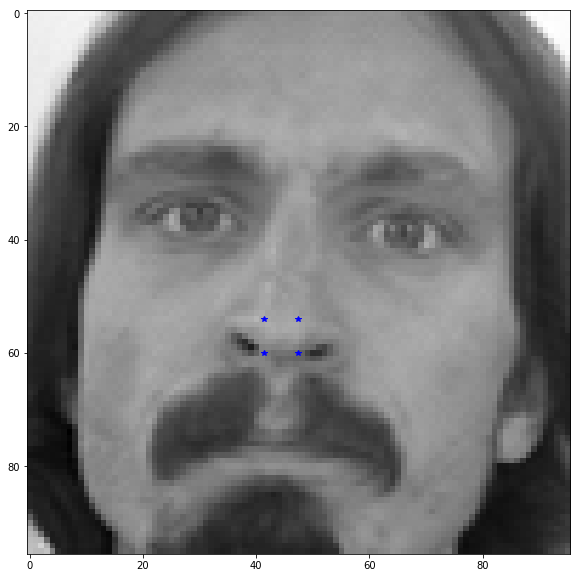

In [6]:
x_center = 44.420571
y_center = 57.066803
off = 3

plt.figure(figsize = (10,10))
plt.imshow(images[0].reshape(96,96), cmap = 'gist_gray')
plt.plot([x_center-off, x_center-off, x_center+off, x_center +off],
         [y_center-off,y_center + off,y_center-off,y_center+off ], 'b*')

## Including reflected pictures to the dataset

In order to increase our dataset I will reflect all images left to right, and add them as different images.

This implies flipping the images, and reflecting all x-coordinates of the keypoints. 

In [5]:
# building an array of reflected images.
flipped_ims = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_ims[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [6]:
# adding the reflected images to our images array. 
# RUN THIS CELL ONLY ONCE. 
images = np.vstack((images, flipped_ims))

In [7]:
# Now the keypoints. I need to switch left and right features, 
# and reflect the x coordinates by x --> 95-x (95 is the last coordinate of the picture. )

reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# We look for the correspoding columns by switching 'left' <--> 'right'.
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    # reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    # the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

In [8]:
# Adding reflected keypoints to the original keypoints. 
# RUN THIS CELL ONLY ONCE.
keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

## Perform a train_test_split in order to have a cross validation set. 

In [9]:
print('Images', images.shape)
print('Keypoints', keypoints.shape)

Images (14098, 9216)
Keypoints (14098, 30)


In [10]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=100, random_state = 42)

##  Define a function for taking random batches. 

In [11]:
def next_batch(X, labels, batch_size):
    
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [12]:
#Some helping functions.
def init_weights(shape):
    init_random_dist = tf.random_normal(shape, stddev=0.1) # Why this stddev?
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.random_uniform(shape=shape)
    return tf.Variable(init_bias_vals)

def init_gamma(shape):
    init_gamma_val = tf.constant(1, dtype = tf.float32)
    return tf.Variable(init_gamma_val)

def init_beta(shape):
    init_beta_val = tf.constant(0, dtype = tf.float32)
    return tf.Variable(init_beta_val)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def output_act_function(input_layer):
    factor = tf.constant(96, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(input_layer))

def sigmoid_layer(input_layer, size, max_val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    factor = tf.constant(max_val, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(tf.matmul(input_layer, W) + b))
    

def bn_layer(input_x, is_training, bn_type = 'normal', decay = 0.999):
    
    """Implements batch normalization. 
    input_x: A Tensor. Is the data to normalize.
    is_training: Bool. Indicates whether we are in training o predictino phase. 
    bn_type: 'normal' or 'convo', indicates over which indeces we take the means. 
              if 'normal', we use only the first index (batch number).
              if 'conv', uses [0,1,2]
    decay: float. decay parameter for the running averages. 
    """
    
    if bn_type == 'normal':
        shape = input_x.shape[1:]
        axes = [0]
    elif bn_type == 'convo':
        shape = input_x.shape[-1]
        axes = [0,1,2]
        
    #running mean and variance to be sued for inference.
    pop_mean = tf.Variable(tf.zeros(shape), trainable=False) 
    pop_var = tf.Variable(tf.ones(shape), trainable=False)
    
    gamma = init_gamma(shape) #in the normalization I am using this is the number of channels. 
    beta = init_beta(shape)
    
    batch_mean, batch_var = tf.nn.moments(input_x, axes)  
    
    def train_phase():
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(input_x, batch_mean, batch_var,
                                                    offset = beta, scale = gamma,
                                                    variance_epsilon=0.0001)
    
    def infer_phase(): 
        return tf.nn.batch_normalization(input_x, pop_mean, pop_var, offset = beta, 
                                  scale = gamma, variance_epsilon=0.0001)
    
        
    return tf.cond(is_training, train_phase, infer_phase)
    

# Building the network

In [13]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)
drop_rate = tf.placeholder(tf.float32)
L = tf.placeholder(tf.float32) # multiplier for the regularization term. 

In [14]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [106]:
# LAYERS

convo1 = convolutional_layer(x_images, [6,6,1,32]) # 6 x 6 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

convo1_pool = max_pool_2by2(convo1)   #output of 24 x 24 x 32

convo2 = convolutional_layer(convo1_pool, [2,2,32,64]) # 4x4 filter, 64 outputs. SAME padding.

convo2_pool = tf.nn.max_pool(convo2, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME') # 12 x 12 x64

convo3 = convolutional_layer(convo2_pool, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

convo3_pool = tf.nn.max_pool(convo3, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME') # 6 x 6 x 128


convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])

full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))

# DROPOUT AND OUTPOUT LAYER

full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

#keypoints_pred = tf.nn.relu(normal_full_layer(full_one_dropout,30))
keypoints_pred = normal_full_layer(full_one_dropout,30)
#added output function to keep outputs below 96

#keypoints_pred = sigmoid_layer(full_one_dropout, 30, 96)

#pre_pred_bn = bn_layer(full_layer_one, is_training =training)
#keypoints_pred = normal_full_layer(pre_pred_bn,30)


In [100]:
# LOSS FUNCTION

masked_mse_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred - keypoints_true, tf.is_finite(keypoints_true) )
    ))

signs = tf.math.sign(tf.subtract(keypoints_pred, tf.constant(96,tf.float32)))

upper_bound_loss = tf.reduce_sum(tf.add(tf.constant(1, tf.float32), signs))

regularized_loss = tf.add(masked_mse_loss, tf.multiply(L,upper_bound_loss))
                                 
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(regularized_loss)

In [107]:
masked_loss = tf.reduce_mean(tf.square( 
    tf.boolean_mask(keypoints_pred - keypoints_true,
                        tf.is_finite(keypoints_true) )
    ))
                                 
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

In [108]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [18]:
counter = 0

## Training

Currently on step 1000
Train MSE:  7.2705255 

CV MSE: 9.881572 

train_losses =  [4627.256, 18.441084, 16.907513, 21.367678, 12.566016, 9.304041, 11.184237, 7.323465, 9.3870125, 6.7716036, 7.2705255] 

cv_losses =  [1329.0051, 20.898178, 15.762244, 14.121304, 11.923594, 11.092145, 11.024193, 9.235763, 9.3338175, 9.112071, 9.881572]


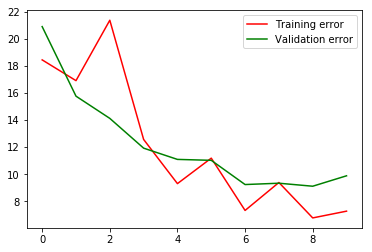

In [109]:
num_steps = 1000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    sess.run(init)
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_3")
    train_losses = []
    cv_losses = []
    
    
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 32)
        
        _ , train_loss= sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                             lr:0.0005, drop_rate:0})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss, feed_dict={x:x_cv,keypoints_true:keypoints_cv, 
                                                         drop_rate:0})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
                        
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_loss, '\n')
    print('CV MSE:', cv_loss, '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    #saver.save(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_3_lay_cnn_1"  )
    #counter +=1
    #print(counter)

In [64]:
np.sqrt(cv_losses[-1])

1.8806261

In [ ]:
counter

## Predictions for the cv set

In [65]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:x_cv, drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_3_lay_cnn_0


In [66]:
predictions.shape

(100, 30)

In [67]:
np.max(predictions)

91.841835

In [35]:
np.unravel_index( np.argmax(predictions), predictions.shape)

(73, 29)

In [37]:
predictions[73,29]

92.808914

In [ ]:
x_cv.shape

In [ ]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'b*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

## Predictions for the test set

In [38]:
test_data = pd.read_csv('test.csv')
test_data.shape

(1783, 2)

In [39]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [40]:
test_images = test_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

test_images = np.vstack([test_images.iloc[i] for i in range(len(test_images))])

In [41]:
saver = tf.train.Saver()

In [68]:
with tf.Session() as sess:
    
    
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_3" )

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:test_images, drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_3_lay_cnn_0


In [69]:
predictions.shape

(1783, 30)

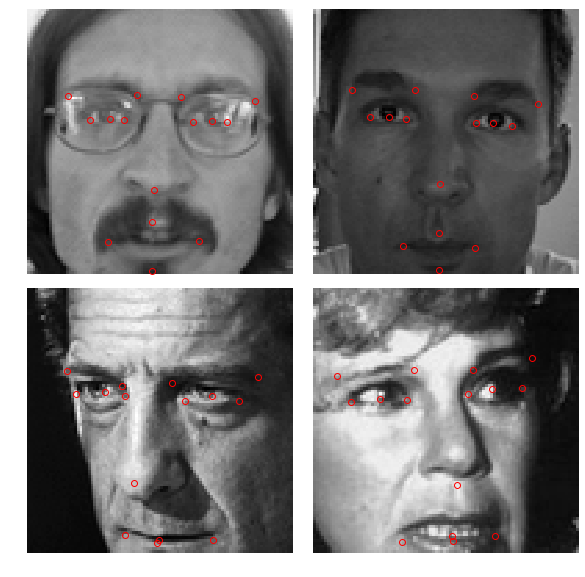

In [70]:
grid_size = 2
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

#selection = np.random.choice(range(len(test_images)), size = grid_size**2 )
selection = [131, 159, 491, 525]
for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(test_images[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    

## Make a dataframe with predictions

In [71]:
predicted_keypoints = pd.DataFrame(data = predictions, columns = keypoints.columns)

In [72]:
predicted_keypoints[(predicted_keypoints>96).any(1)]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y


In [73]:
predicted_keypoints.to_csv('full_test_predictions_002.csv')

## Loading the lookup table to make a submission file. 

In [74]:
lookup_table = pd.read_csv('IdLookupTable.csv', header = 0, index_col = 'RowId')

In [75]:
locations_list = []
for i in lookup_table.iterrows():
    position = predicted_keypoints.iloc[i[1]['ImageId']-1][i[1]['FeatureName']]
    locations_list.append(position)
len(locations_list)

27124

In [76]:
#empty dataframe for testing submission
Submission_df = pd.DataFrame(columns = ['Location'], index = lookup_table.index)

In [77]:
Submission_df['Location'] = locations_list

In [78]:
Submission_df.to_csv('submission_002.csv')